---
title: "Buy vs. Rent, A Financial Modeling Workflow in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2022-8-6"
description: "Using `numpy-financial` and monte-carlo simulation to evaluate investments."
draft: false
categories:  ['Python', 'Probability']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

We now simulate market returns for every month by supplying mean and standard deviation values for both home and stock market appreciation and drawing 360 samples (360 months in 30 years). For simplicity, we'll just use world-wide aggregate values from ["The Rate of Return on Everything, 1870-2015"](https://www.frbsf.org/economic-research/wp-content/uploads/sites/4/wp2017-25.pdf).


In [2]:
mu_stock = .1081
sigma_stock = .2267

mu_home = .0572
sigma_home = .1042

Given that stock and home appreciation is probably correlated, I'll have ti sample from a bivariate normal distribution using `numpy.random.Generator.multivariate_normal` - documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), rather than the univariate distribution draw shown above. I am going to assume a correlation coefficient, $\rho_{stock,home}$ of 0.5 - a fairly clear correlation.  
In order to use that numpy function, I'll need to translate my correlation statistic into a covariance statistic, and I'll use the following formula ([source](https://en.wikipedia.org/wiki/Correlation)):  
$$ \begin{align*}
cov_{stock,home} &= \rho_{stock,home} \times \sigma_{stock} \sigma_{home} \\\
cov_{stock,home} &= 0.5 \times .2267 \times .1042 \end{align*}
$$

I calculate covariance and confirm that the covariance and correlations match up below:


In [3]:
cov = 0.5 * sigma_stock * sigma_home
print("Covariance:", cov)
print("Back to correlation:", cov / (sigma_stock * sigma_home))

Covariance: 0.01181107
Back to correlation: 0.5


Now that I have the covariance, I'll be able to sample from a bivariate normal distribution of the form shown below ([source](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2)).    
$$
\begin{pmatrix} Stock \\\\ Home\end{pmatrix} \sim \mathcal{N} \left[ \begin{pmatrix} \mu_{s} \\\ \mu_{h}\end{pmatrix}, \begin{pmatrix} \sigma_{s}^2 & cov_{s,h} \\\ cov_{s,h} & \sigma_{h}^2\end{pmatrix} \right]
$$  

*Note, $s$ is shorthand for stock and $h$ is shorthand for home.*  
  
Now I'll code that in Python and confirm that the means and standard deviations of our samples match what we expect:


In [4]:
def simulate_returns(mu_stock=.1081,
                     sigma_stock=.2267,
                     mu_home=.0572,
                     sigma_home=.1042,
                     condo_cost = .02,
                     years = 30,
                     seed=None):
    cov = 0.5 * sigma_stock * sigma_home
    cov_matrix = np.array([[sigma_stock**2, cov],
                [cov, sigma_home**2]])
    returns_df = pd.DataFrame(np.random
                            .default_rng(seed)
                            .multivariate_normal([mu_stock, mu_home],
                                                cov_matrix,
                                                years * 12),
                            columns=["Stock_Appreciation", "Home_Appreciation"])
    returns_df['Stock_Appreciation'] = returns_df['Stock_Appreciation'] * .6
    returns_df['Condo_Appreciation'] = returns_df['Home_Appreciation'] - condo_cost + np.random.normal(0, .005, len(returns_df))
    returns_df = (returns_df / 12)
    returns_df.index = pd.date_range(
        start=datetime.today().date(),
        periods=12*years,
        freq='MS',
        name="Date")
    return returns_df

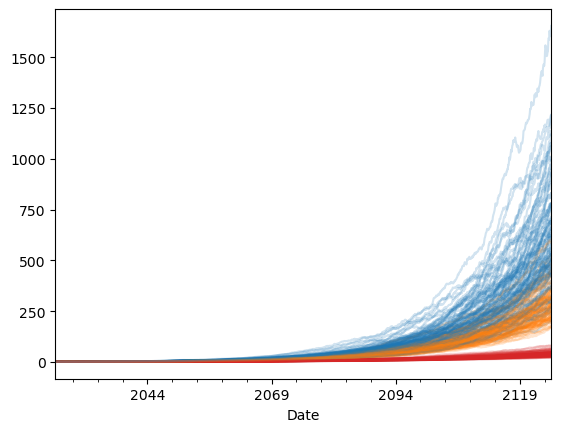

In [5]:
fig, ax = plt.subplots()
for i in range(100):
    returns_df = simulate_returns(years = 100)
    cum_returns = returns_df.add(1).cumprod()
    cum_returns['Home_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:orange")
    cum_returns['Condo_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:red")
    cum_returns['Stock_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:blue")

In [6]:
returns_df

,Stock_Appreciation,Home_Appreciation,Condo_Appreciation
Date,,,
2025-06-01,0.007834,-0.004850,-0.006958
2025-07-01,-0.014353,-0.007160,-0.008342
2025-08-01,0.000612,0.004163,0.002494
2025-09-01,0.019203,-0.008180,-0.009044
2025-10-01,0.014614,0.008431,0.006547
...,...,...,...
2125-01-01,-0.007270,-0.016993,-0.018222
2125-02-01,0.023520,0.009568,0.007348
2125-03-01,-0.008009,0.006778,0.005055


In [7]:
def salt_deduction(property_tax):
    """Caps SALT deduction (property + state income tax) at $10,000"""
    return np.minimum(property_tax, 10000)

def itemized_vs_standard_deduction(itemized, standard_deduction=14600):
    """Chooses the better deduction (standard or itemized)"""
    return np.maximum(itemized, standard_deduction)

def apply_compounding(growth, start, deposits):
    growth = np.array(growth)
    deposits = np.array(deposits)
    balance = float(start)
    balances = []
    for i in range(len(growth)):
        balance = (balance + deposits[i]) * (1 + growth[i])
        balances.append(balance)
    return balances

def initiate_model(today, years = 30):
    df_own = pd.DataFrame()
    df_own["Period"] =  pd.Series(range(12*years)) + 1
    df_own["Date"] = pd.date_range(
        start=today,
        periods=12*years,
        freq='MS',
        name="Date")
    df_own = df_own.set_index('Date')
    return df_own

def mortgage_calc(df_own, interest_rate, principal):
     # Ensure "Period" column is an integer
    df_own = df_own.copy()
    df_own["Period"] = df_own["Period"].astype(int)

    # Loan term in months
    loan_term_months = 12 * 30
    
    # Compute principal and interest payments
    df_own["Principal_monthly"] = npf.ppmt(interest_rate / 12, df_own["Period"], loan_term_months, principal) * -1
    df_own["Interest_monthly"] = npf.ipmt(interest_rate / 12, df_own["Period"], loan_term_months, principal) * -1

    # Zero out values beyond the loan term
    df_own.loc[df_own["Period"] > loan_term_months, ["Principal_monthly", "Interest_monthly"]] = 0

    return df_own

today = datetime.today().date()

In [8]:
def owner_table(interest_rate=0.065,
                renovation=0,
                cost=1000000,
                hoa=0,
                returns_df=returns_df,
                mean_reno_return=.5,
                cg_tax=.15,
                buying_fees=0.04,
                selling_fees=.07,
                pct_down=.2,
                condo=False,
                start_date=None,
                years=30,
                upgrade=None,
                avg_income_growth = .02,
                upgrade_cost_today=1500000,
                max_monthly=8300,
                max_down=300000,
                pay_back_parents_years = 10,
                verbose=False):
    
    if not start_date:
        today = datetime.today().date()
    else:
        today = start_date
    df_own = initiate_model(today, years=years)
    is_year = df_own.index.month == 1
    df_own = df_own.merge(returns_df, left_index=True, right_index=True, how="left")
    
    down_payment = cost * pct_down
    principal = cost - down_payment
    buying_fees = cost*.04
    reno_return = np.random.lognormal(np.log(mean_reno_return), 0.2)
    post_reno_value = (cost + renovation * reno_return)
    year = is_year.cumsum()

    df_own["Purchase_cost"] = buying_fees + down_payment + renovation
    df_own = mortgage_calc(df_own, interest_rate, principal)
    df_own['HOA_monthly'] = hoa
    df_own["PropTax_monthly"] = np.round((cost * 1.02**((year)) * 0.0144) / 12, 2)
    df_own['Max_Monthly'] = np.round((max_monthly * 1.02**((year))), 2)
    annual_proptax = df_own.resample("YE")['PropTax_monthly'].sum().rename("PropTax_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_proptax, left_index=True, right_index=True, how="left"
        )
    annual_interest = df_own.resample("YE")['Interest_monthly'].sum().rename("Interest_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_interest, left_index=True, right_index=True, how="left"
        )
    df_own['Total_deduction'] = itemized_vs_standard_deduction(
        df_own['Interest_annual'] + df_own["PropTax_annual"].apply(salt_deduction)
        )
    df_own['Tax_Savings_annual'] = (df_own['Total_deduction'] * 0.24 + df_own['Total_deduction'] * 0.093)
    df_own['Tax_Savings_monthly'] = df_own['Tax_Savings_annual'] / 12
    df_own['Pre_tax_monthly'] = df_own[["Principal_monthly", "Interest_monthly", "PropTax_monthly", "HOA_monthly"]].sum(axis=1)
    df_own['Post_tax_monthly'] = df_own['Pre_tax_monthly'] - df_own['Tax_Savings_monthly']
    df_own['Unproductive_cost'] = df_own['Post_tax_monthly'] - df_own["Principal_monthly"]
    df_own["Balance_Remaining"] = principal - df_own["Principal_monthly"].cumsum()
    if condo:
        df_own["Home_Value"] = apply_compounding(growth=df_own['Condo_Appreciation'],
                                            start=post_reno_value,
                                            deposits=np.zeros_like(df_own['Condo_Appreciation'])
                                            ) 
    else:
        df_own["Home_Value"] = apply_compounding(growth=df_own['Home_Appreciation'],
                                                start=post_reno_value,
                                                deposits=np.zeros_like(df_own['Home_Appreciation'])
                                                ) 
        df_own = df_own.drop(columns=['Condo_Appreciation', 'HOA_monthly'])
    
    df_own["Sale_fee"] = df_own["Home_Value"] * selling_fees
    df_own['Capital_gain'] = (df_own["Home_Value"] - cost)
    df_own["Sale_tax"]  = np.maximum(0, (df_own['Capital_gain'] - 500000)) * cg_tax
    df_own['Profit'] = df_own['Capital_gain'] - df_own["Sale_tax"] - df_own["Sale_fee"] - buying_fees + down_payment + df_own["Principal_monthly"].cumsum()
    # Opp Costs
    added_costs = np.zeros_like(df_own['Post_tax_monthly'].values)
    if df_own["Purchase_cost"].iloc[0] <= max_down:
        savings_1 = (max_down - df_own["Purchase_cost"].iloc[0])
    else:
        savings_1 = 0
        additional_monthly = (df_own["Purchase_cost"].iloc[0] - max_down) / pay_back_parents_years / 12
        added_costs[:pay_back_parents_years*12] = additional_monthly
        if verbose:
            print("\tTotal Reno:", renovation)
            print("\tReno excess monthly:", additional_monthly)
        df_own['Pre_tax_monthly'] = df_own['Pre_tax_monthly'] + added_costs
        df_own['Post_tax_monthly'] = df_own['Post_tax_monthly'] + added_costs

    diff_0 = df_own['Max_Monthly'] - df_own['Post_tax_monthly'] - added_costs
    diff_0[diff_0 < 0] = 0
    df_own['Stock_savings'] = (
        pd.Series(apply_compounding(df_own['Stock_Appreciation'],
                                    0,
                                    diff_0)).multiply(.85).values +
                                    pd.Series(apply_compounding(
                                        df_own['Stock_Appreciation'],
                                        savings_1,
                                        np.zeros_like(df_own['Stock_Appreciation']))).multiply(.85).values
    )
    df_own['Full_profit'] = df_own['Stock_savings'] + df_own['Profit']
    if upgrade is not None:
        house_2_max_dp = df_own['Full_profit'][upgrade]
        years_elapsed = pd.to_datetime(upgrade).year - today.year - 1
        house_2_max_monthly = max_monthly * (1 + avg_income_growth)**int(years_elapsed)
        df_own['_upgrade'] = apply_compounding(growth=df_own['Home_Appreciation'],
                                         start=upgrade_cost_today,
                                         deposits=np.zeros_like(
                                             df_own['Home_Appreciation'])
                                         )
        house_2_cost = df_own.loc[upgrade, '_upgrade']
        new_house = pd.concat([
            df_own[:upgrade].iloc[:-1],
            owner_table(start_date=upgrade,
                        cost=house_2_cost,
                        years=years,
                        max_down=house_2_max_dp,
                        max_monthly=house_2_max_monthly)
            ]).iloc[:years*12]
        if verbose:
            print("Upgrade house price:", house_2_cost)
            print("\tmonthly postax Year 1:", new_house.loc[upgrade, 'Post_tax_monthly'])
            print("\tmonthly interest+tax Year 1:", new_house.loc[upgrade, 'Unproductive_cost'])
            print("\tmonthly pretax", new_house.loc[upgrade, 'Pre_tax_monthly'])
        return new_house
    else:
        return df_own

In [9]:
owner_table(years=30, upgrade='2027-01-01')[['Stock_savings',
                                             'Capital_gain',
                                             'Sale_fee',
                                             'Full_profit',
                                             'Home_Value',
                                             'Max_Monthly']].loc["2026-01-01":].head(20)

,Stock_savings,Capital_gain,Sale_fee,Full_profit,Home_Value,Max_Monthly
Date,,,,,,
2026-01-01,76149.342868,4126.033483,70288.822344,175883.124180,1.004126e+06,8466.00
2026-02-01,77708.388101,-9601.228467,69327.914007,165430.966409,9.903988e+05,8466.00
2026-03-01,80681.106150,-5492.744018,69615.507919,172983.816005,9.945073e+05,8466.00
2026-04-01,83124.641229,-1808.951460,69873.373398,179616.631727,9.981910e+05,8466.00
2026-05-01,86856.100263,5454.278104,70381.799467,190870.382651,1.005454e+06,8466.00
2026-06-01,92163.100118,8055.559469,70563.889163,199368.219801,1.008056e+06,8466.00
2026-07-01,96174.618609,19126.673742,71338.867162,214451.699938,1.019127e+06,8466.00
2026-08-01,99319.377978,22018.627949,71541.303956,221066.004478,1.022019e+06,8466.00
2026-09-01,103245.039181,23008.284242,71610.579897,226696.298945,1.023008e+06,8466.00


<AxesSubplot: xlabel='Date'>

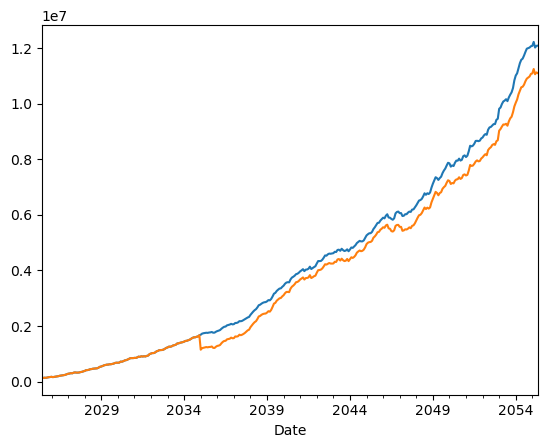

In [10]:
owner_table(years=30)['Full_profit'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Full_profit'].plot()

<AxesSubplot: xlabel='Date'>

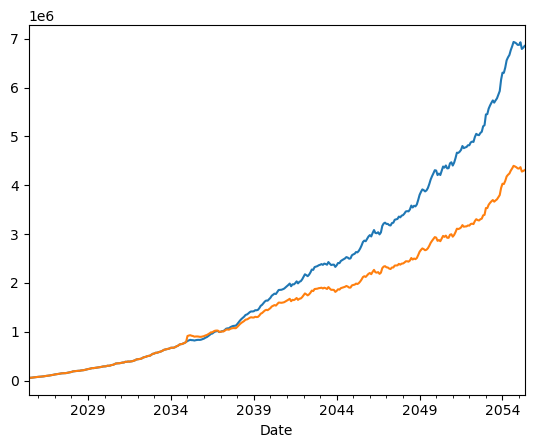

In [11]:
owner_table(years=30)['Stock_savings'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Stock_savings'].plot()

<AxesSubplot: xlabel='Date'>

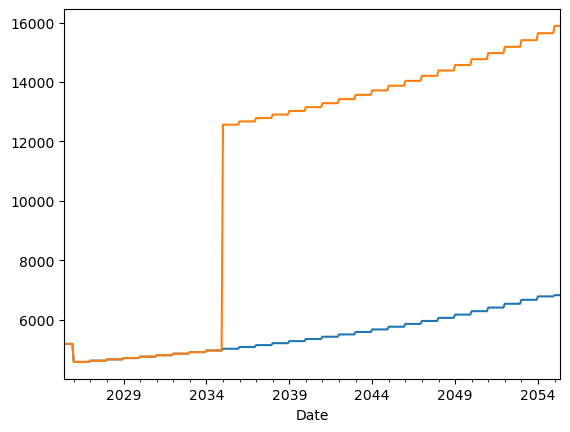

In [12]:
owner_table(years=30)['Post_tax_monthly'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Post_tax_monthly'].plot()

In [13]:
def compare(scenario_1, scenario_2, returns_df, verbose=False, max_monthly=8000, max_down=300000):
    series_1 = owner_table(**scenario_1)
    series_2 = owner_table(**scenario_2)
    both = [series_1, series_2]
    if verbose:
        print(scenario_1['cost'])
        print("\tmonthly postax Year 1:", series_1['Post_tax_monthly'].iloc[0])
        print("\tmonthly interest+tax Year 1:", series_1['Unproductive_cost'].iloc[0])
        print("\tmonthly postax Year 2:", series_1['Post_tax_monthly'].loc['2026-01-01'])
        print("\tmonthly interest+tax Year 2:", series_1['Unproductive_cost'].loc['2026-01-01'])
        print("\tmonthly pretax", series_1['Pre_tax_monthly'].iloc[0])
        print(scenario_2['cost'])
        print("\tmonthly postax Year 1:", series_2['Post_tax_monthly'].iloc[0])
        print("\tmonthly interest+tax Year 1:", series_2['Unproductive_cost'].iloc[0])
        print("\tmonthly postax Year 2:", series_2['Post_tax_monthly'].loc['2026-01-01'])
        print("\tmonthly interest+tax Year 2:", series_2['Unproductive_cost'].loc['2026-01-01'])
        print("\tmonthly pretax", series_2['Pre_tax_monthly'].iloc[0])
    total_cost_1 = series_1['Purchase_cost'].iloc[0]
    total_cost_2 = series_2['Purchase_cost'].iloc[0]
    if verbose:
        print(scenario_1['cost'])
        print("\tupfront cost", total_cost_1)
        print(scenario_2['cost'])
        print("\tupfront cost", total_cost_2)
        print("\tDifference", (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)))
    savings_1 = (max_down - total_cost_1) if (max_down - total_cost_1) > 0 else 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_1,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    savings_2 = (max_down - total_cost_2) if (max_down - total_cost_2) > 0 else 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_2,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    ##
    ##
    diff_0 = max_monthly - both[0]['Post_tax_monthly']
    diff_0[diff_0 < 0] = 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_0)
                                                                ).multiply(.85)
    diff_1 = max_monthly - both[1]['Post_tax_monthly']
    diff_1[diff_1 < 0] = 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_1)
                                                                ).multiply(.85)
    ##
    final_profit_1 = both[0]['Profit'].iloc[-1]
    final_profit_2 = both[1]['Profit'].iloc[-1]
    if verbose:
        print(scenario_1['cost'])
        print("\tFinal", final_profit_1)
        print(scenario_2['cost'])
        print("\tFinal", final_profit_2) 
    return both 

1100000
	monthly postax Year 1: 6356.623477338249
	monthly interest+tax Year 1: 5069.32867317338
	monthly postax Year 2: 5688.42942893578
	monthly interest+tax Year 2: 4370.827973416708
	monthly pretax 7575.628137498203
1150000
	monthly postax Year 1: 5313.651817217261
	monthly interest+tax Year 1: 4058.75270377217
	monthly postax Year 2: 4627.698948432861
	monthly interest+tax Year 2: 3341.1156085720113
	monthly pretax 6588.065780111758
1100000
	upfront cost 364000.0
1150000
	upfront cost 356000.0
	Difference 8000.0
1100000
	Final 4775992.7946815565
1150000
	Final 4049314.445720141
	Total Reno: 100000
	Reno excess monthly: 533.3333333333334
	Total Reno: 80000
	Reno excess monthly: 466.6666666666667


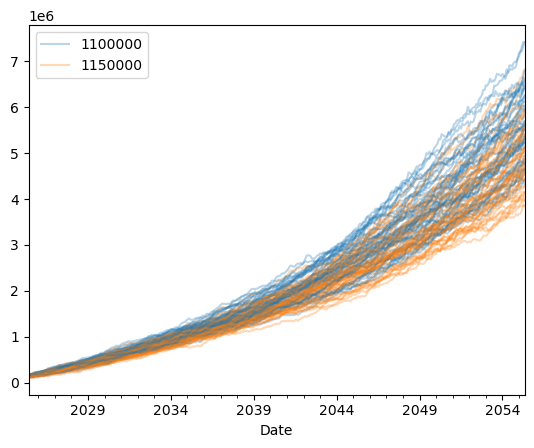

In [31]:
fig, ax = plt.subplots()
profits = {}
yr_10 = {}
yr_20 = {}
yr = {}
ir = 0.06775
for i in range(50):
    returns_df = simulate_returns()
    # No Reno
    scenario_1 = {'cost': 1_100_000, 'renovation': 100000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    duplex = {'cost': 1_150_000, 'renovation': 80_000,
                  'hoa':-1241, 'condo': True,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    # Reno
    berkeley_way = {'cost': 1_050_000, 'renovation': 100_000,
                  'mean_reno_return': 2,
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    acroft = {'cost': 1_200_001, 'renovation': 120_000,
                  'mean_reno_return': 2,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    mcgee = {'cost': 1_250_001, 'renovation': 10_000,
              'mean_reno_return': 1,
              'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    upgrader = {'cost': 1_100_000, 'renovation': 10_000,
              'mean_reno_return': .1,
              'upgrade': '2033-01-01',
              'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}

    scenario_2 = duplex
    
    if i == 0:
        both = compare(scenario_1, scenario_2, returns_df, verbose=True)
        series_1 = owner_table(verbose=True, **scenario_1)
        series_2 = owner_table(verbose=True, **scenario_2)
        profits[str(scenario_1['cost'])] = []
        profits[str(scenario_2['cost'])] = []
        profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
        profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
        yr[str(scenario_1['cost'])] = []
        yr[str(scenario_2['cost'])] = []
        yr[str(scenario_1['cost'])].append(both[0]['Profit'])
        yr[str(scenario_2['cost'])].append(both[1]['Profit'])
        yr_10[str(scenario_1['cost'])] = []
        yr_10[str(scenario_2['cost'])] = []
        yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
        yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
        yr_20[str(scenario_1['cost'])] = []
        yr_20[str(scenario_2['cost'])] = []
        yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
        yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
        both[0]['Profit'].plot(ax=ax, label=str(scenario_1['cost']), color="tab:blue", alpha=.3)
        both[1]['Profit'].plot(ax=ax, label=str(scenario_2['cost']), color="tab:orange", alpha=.3)
    else:
       both = compare(scenario_1, scenario_2, returns_df)
       profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
       profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
       yr[str(scenario_1['cost'])].append(both[0]['Profit'])
       yr[str(scenario_2['cost'])].append(both[1]['Profit'])
       yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
       yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
       yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
       yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
       both[0]['Profit'].plot(ax=ax, label="_k", color="tab:blue", legend=False, alpha=.3)
       both[1]['Profit'].plot(ax=ax, label="_l", color="tab:orange", legend=False, alpha=.3) 
outcomes_df = pd.concat([
    pd.concat(yr[str(scenario_1['cost'])], axis=1).T.assign(variable=str(scenario_1['cost'])),
    pd.concat(yr[str(scenario_2['cost'])], axis=1).T.assign(variable=str(scenario_2['cost']))
])
outcomes_df.columns = both[0].index.astype(str).tolist() + outcomes_df.columns[len(both[0]):].tolist()
ax.legend();

In [32]:
selection = '2032-01-01'
df_select = outcomes_df[[selection, 'variable']]
df_select = df_select.rename(columns={selection: 'value'})
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data=df_select).fit(q=0.5)
print("Q-Reg:")
print(mod.summary().tables[-1])
mod = sm.OLS.from_formula("value ~ I(variable)", data=df_select).fit()
print("Linear-Reg:")
print(mod.summary().tables[1])

Q-Reg:
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.189e+05   1.62e+04     44.471      0.000    6.87e+05    7.51e+05
I(variable)[T.1150000] -3.473e+04   2.29e+04     -1.519      0.132   -8.01e+04    1.06e+04
Linear-Reg:
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.321e+05    1.1e+04     66.566      0.000     7.1e+05    7.54e+05
I(variable)[T.1150000] -4.304e+04   1.56e+04     -2.767      0.007   -7.39e+04   -1.22e+04


In [33]:
df_select.groupby('variable')['value'].agg(['mean', 'median'])

,mean,median
variable,,
1100000,732125.204835,717551.292392
1150000,689086.985252,682286.566478


#### 10yr

In [34]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_10).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.11e+06,2.23e+04,49.743,0.000,1.07e+06,1.15e+06
I(variable)[T.1150000],-6.362e+04,3.15e+04,-2.017,0.046,-1.26e+05,-1022.033


In [35]:
mod.params.iloc[-1]/10/12

-530.1992846074514

#### 20 yr

In [36]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_20).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.788e+06,7.26e+04,38.382,0.000,2.64e+06,2.93e+06
I(variable)[T.1150000],-2.838e+05,1.03e+05,-2.763,0.007,-4.88e+05,-8e+04


In [37]:
mod.params.iloc[-1]/20/12

-1182.6495246134698

#### 30 yr

In [38]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(profits).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.565e+06,1.56e+05,35.637,0.000,5.25e+06,5.87e+06
I(variable)[T.1150000],-6.897e+05,2.21e+05,-3.123,0.002,-1.13e+06,-2.52e+05
